### 股票数据维度信息提取


数据格式


第一行：600000 浦发银行 日线 前复权

其他如下：

|   日期	  |开盘|	最高	| 最低|	   收盘|	 成交量|	  成交额|
|--|--|--|--|--|--|--|
|2010/01/04	|10.44	|10.46|	10.04	|10.06|	66191338	|1419984128.00|
|2010/01/05	|10.19	|10.29	|9.82	|10.15	|115147943|	2436890880.00|
|2010/01/06|	10.12|	10.12|	9.88|	9.91|	96782575|	2034174080.00|
|2010/01/07|	9.88|	9.97|	9.53|	9.63|	85236072|	1761800960.00|
|2010/01/08|	9.56|	9.83|	9.53|	9.76|	65707646|	1349532416.00|
|2010/01/11|	10.30|	10.42	|9.69|	9.76|	116304812|	2456818944.00|

In [1]:
# 导包
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import pairwise_distances_argmin
import warnings

In [2]:
def expand(a, b):
    d = (b - a) * 0.05
    return a-d, b+d

In [3]:
warnings.filterwarnings("ignore")   # hmmlearn(0.2.0) < sklearn(0.18)

In [4]:
# 加载数据
# 0日期  1开盘  2最高  3最低  4收盘  5成交量  6成交额
# delimiter: 指定分隔符
# skiprows：给定前面多少行数据不进行处理
# usecols: 给定第4 5 6 2 3这五列数据进行读入(下标从0开始)
x = np.loadtxt('SH600000.txt', delimiter='\t', skiprows=2, usecols=(4, 5, 6, 2, 3))
close_price = x[:, 0] # 收盘价
volumn = x[:, 1] # 成交量
amount = x[:, 2] # 成交额
amplitude_price = x[:, 3] - x[:, 4] # 每天的最高价与最低价的差
diff_price = np.diff(close_price)   # 涨跌值(每天相对于昨天的涨跌幅)
volumn = volumn[1:]                 # 成交量(今天的成交量)
amount = amount[1:]                 # 成交额(今天的成交额度)
amplitude_price = amplitude_price[1:]   # 每日振幅(今天的振幅)
sample = np.column_stack((diff_price, volumn, amount, amplitude_price))    # 观测值
print("样本量:%d， 特征数目:%d" % sample.shape)
sample

样本量:1510， 特征数目:4


array([[ 9.00000000e-02,  1.15147943e+08,  2.43689088e+09,
         4.70000000e-01],
       [-2.40000000e-01,  9.67825750e+07,  2.03417408e+09,
         2.40000000e-01],
       [-2.80000000e-01,  8.52360720e+07,  1.76180096e+09,
         4.40000000e-01],
       ...,
       [ 3.40000000e-01,  3.56315260e+07,  6.50177344e+08,
         4.80000000e-01],
       [-1.00000000e-01,  1.83124240e+07,  3.33790688e+08,
         2.20000000e-01],
       [-1.70000000e-01,  1.77865250e+07,  3.21768768e+08,
         3.70000000e-01]])

In [5]:
# 模型构建
# 给定隐特征的数目
n = 5
model = hmm.GaussianHMM(n_components=n, covariance_type='full')
model.fit(sample)
y = model.predict_proba(sample) # 获取预测的概率
print(y)
print(model.predict(sample)) # 获取预测状态值

[[0.00000000e+00 9.99999985e-01 1.52749201e-08 1.58356115e-36
  9.23914059e-30]
 [3.58310341e-88 9.97365960e-01 2.32524251e-03 1.61437918e-04
  1.47359341e-04]
 [1.38523066e-64 9.89876465e-01 8.93312845e-04 9.20087920e-03
  2.93429140e-05]
 ...
 [2.29677449e-16 1.33036108e-02 3.61942562e-08 9.86696353e-01
  3.68711732e-10]
 [6.61131569e-04 7.04717556e-04 6.79274845e-07 9.98633469e-01
  2.99599431e-09]
 [8.44340618e-06 6.71036550e-03 6.38419217e-05 9.93216877e-01
  4.71797146e-07]]
[1 1 1 ... 3 3 3]


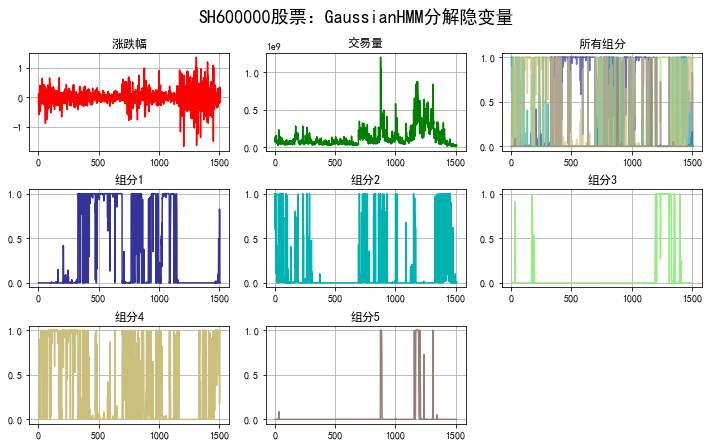

In [6]:
# 画图
t = np.arange(len(diff_price))
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,8), facecolor='w')
plt.subplot(431)
plt.plot(t, diff_price, 'r-')
plt.grid(True)
plt.title(u'涨跌幅')
plt.subplot(432)
plt.plot(t, volumn, 'g-')
plt.grid(True)
plt.title(u'交易量')

# 产生一个颜色
clrs = plt.cm.terrain(np.linspace(0, 0.8, n))
plt.subplot(433)
for i, clr in enumerate(clrs):
    # 画到一张图中
    plt.plot(t, y[:, i], '-', color=clr, alpha=0.7)
plt.title(u'所有组分')
plt.grid(True)

# 分开画
for i, clr in enumerate(clrs):
    plt.subplot(4, 3, i+4)
    plt.plot(t, y[:, i], '-', color=clr)
    plt.title(u'组分%d' % (i+1))
    plt.grid(True)
plt.suptitle(u'SH600000股票：GaussianHMM分解隐变量', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()